## 📰 News Category Prediction

Given *headlines of news articles*, let's try to predict the **category** of the article.

We will use a TensorFlow/Keras neural network with word embeddings to make our predictions.

Data source: https://www.kaggle.com/datasets/rmisra/news-category-dataset

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

2025-03-24 09:48:36.466615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_json('News_Category_Dataset_v3.json', lines=True)
data

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


### Preprocessing

In [5]:
df = data.copy()

In [9]:
mapping = dict(enumerate(df['category'].unique()))
LABEL_MAPPING = {value: key for key, value in mapping.items()}
LABEL_MAPPING

{'U.S. NEWS': 0,
 'COMEDY': 1,
 'PARENTING': 2,
 'WORLD NEWS': 3,
 'CULTURE & ARTS': 4,
 'TECH': 5,
 'SPORTS': 6,
 'ENTERTAINMENT': 7,
 'POLITICS': 8,
 'WEIRD NEWS': 9,
 'ENVIRONMENT': 10,
 'EDUCATION': 11,
 'CRIME': 12,
 'SCIENCE': 13,
 'WELLNESS': 14,
 'BUSINESS': 15,
 'STYLE & BEAUTY': 16,
 'FOOD & DRINK': 17,
 'MEDIA': 18,
 'QUEER VOICES': 19,
 'HOME & LIVING': 20,
 'WOMEN': 21,
 'BLACK VOICES': 22,
 'TRAVEL': 23,
 'MONEY': 24,
 'RELIGION': 25,
 'LATINO VOICES': 26,
 'IMPACT': 27,
 'WEDDINGS': 28,
 'COLLEGE': 29,
 'PARENTS': 30,
 'ARTS & CULTURE': 31,
 'STYLE': 32,
 'GREEN': 33,
 'TASTE': 34,
 'HEALTHY LIVING': 35,
 'THE WORLDPOST': 36,
 'GOOD NEWS': 37,
 'WORLDPOST': 38,
 'FIFTY': 39,
 'ARTS': 40,
 'DIVORCE': 41}

In [10]:
NUM_CLASSES = len(LABEL_MAPPING)
print("# of classes: ", NUM_CLASSES)

# of classes:  42


In [11]:
# Use only the headline and category columns
df = df.loc[:, ['headline', 'category']]

df

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS
...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS


In [12]:
df['category'].value_counts()

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

In [13]:
# Sample 1000 examples from each category
category_samples = []

for category in df['category'].unique():
    category_slice = df.query('category == @category')
    category_samples.append(category_slice.sample(1000, random_state=1))

df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [14]:
df

,headline,category
0,Bill Clinton Tells Grads To Focus On The Futur...,COLLEGE
1,Cruise Ship Circles Off California Coast After...,U.S. NEWS
2,General's Appointment To Muslim World’s NATO H...,THE WORLDPOST
3,These Celebs Wore Heels Where?,STYLE & BEAUTY
4,Are We There Yet?,WELLNESS
...,...,...
41995,Andy Samberg With A Decent Summary Of 'Girls' ...,ENTERTAINMENT
41996,Ryan Lochte Makes A Splash With His Shocking N...,STYLE
41997,Instagram Rolls Out Focus Feature That Rivals ...,TECH
41998,Feds Charge Ahmad Khan Rahami For Planting New...,CRIME


In [16]:
df['category'].value_counts()

category
COLLEGE           1000
STYLE             1000
TRAVEL            1000
WORLD NEWS        1000
RELIGION          1000
WEDDINGS          1000
PARENTS           1000
WORLDPOST         1000
CULTURE & ARTS    1000
ENVIRONMENT       1000
PARENTING         1000
U.S. NEWS         1000
GOOD NEWS         1000
BUSINESS          1000
POLITICS          1000
FIFTY             1000
GREEN             1000
MEDIA             1000
MONEY             1000
COMEDY            1000
ARTS & CULTURE    1000
BLACK VOICES      1000
HOME & LIVING     1000
FOOD & DRINK      1000
THE WORLDPOST     1000
STYLE & BEAUTY    1000
WELLNESS          1000
WOMEN             1000
TECH              1000
WEIRD NEWS        1000
DIVORCE           1000
IMPACT            1000
SPORTS            1000
LATINO VOICES     1000
SCIENCE           1000
ENTERTAINMENT     1000
EDUCATION         1000
HEALTHY LIVING    1000
QUEER VOICES      1000
TASTE             1000
CRIME             1000
ARTS              1000
Name: count, dtype: int64

In [18]:
# Map the labels to integers
df['category'] = df['category'].replace(LABEL_MAPPING)
df

/tmp/ipykernel_4709/2890736512.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category'] = df['category'].replace(LABEL_MAPPING)


,headline,category
0,Bill Clinton Tells Grads To Focus On The Futur...,29
1,Cruise Ship Circles Off California Coast After...,0
2,General's Appointment To Muslim World’s NATO H...,36
3,These Celebs Wore Heels Where?,16
4,Are We There Yet?,14
...,...,...
41995,Andy Samberg With A Decent Summary Of 'Girls' ...,7
41996,Ryan Lochte Makes A Splash With His Shocking N...,32
41997,Instagram Rolls Out Focus Feature That Rivals ...,5
41998,Feds Charge Ahmad Khan Rahami For Planting New...,12


In [40]:
# Split df into X and y
y = df['category'].copy()
X = df['headline'].copy()

In [41]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [42]:
len(X_train), len(X_test)

(29399, 12601)

In [43]:
y_train.value_counts()

category
1     730
16    719
13    715
14    713
12    713
39    713
27    712
31    712
32    711
22    710
17    710
23    707
11    707
24    707
20    707
30    707
0     707
26    707
29    705
33    704
34    703
37    700
8     700
18    700
38    700
21    699
41    698
7     695
28    693
35    692
2     691
36    689
25    686
40    686
19    686
15    685
5     684
10    683
9     683
3     681
6     680
4     669
Name: count, dtype: int64

In [44]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    return sequences

In [45]:
# Fit a tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [46]:
# Get sequence data
X_train = get_sequences(X_train, tokenizer)

In [47]:
X_train[0]

array([332, 168, 409,  32,  14,   2, 579, 409,  32,  21, 109,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [48]:
X_train.shape

(29399, 26)

In [49]:
X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])

In [50]:
X_train.shape, X_test.shape

((29399, 26), (12601, 26))

### Modeling

In [52]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

embedding = tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64
)(inputs)

2025-03-24 11:12:12.257733: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [53]:
inputs

<KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'input_2')>

In [54]:
embedding

<KerasTensor: shape=(None, 26, 64) dtype=float32 (created by layer 'embedding')>

In [55]:
flatten = tf.keras.layers.Flatten()(embedding)

In [56]:
flatten

<KerasTensor: shape=(None, 1664) dtype=float32 (created by layer 'flatten')>

In [57]:
dense_1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)

In [58]:
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_2)

In [59]:
model = tf.keras.Model(inputs, outputs)

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 64)            640000    
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 128)               213120    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 42)                5418      
                                                                 
Total params: 875,050
Trainable params: 875,050
Non-trainable

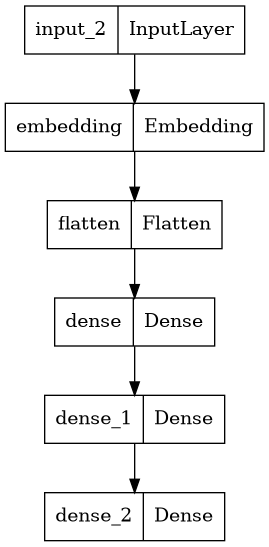

In [62]:
tf.keras.utils.plot_model(model)

### Training

In [63]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
735/735 [==============================] - 20s 26ms/step - loss: 3.4774 - accuracy: 0.0812 - val_loss: 3.0070 - val_accuracy: 0.1755
Epoch 2/100
735/735 [==============================] - 19s 26ms/step - loss: 2.3665 - accuracy: 0.3413 - val_loss: 2.6260 - val_accuracy: 0.3036
Epoch 3/100
735/735 [==============================] - 18s 24ms/step - loss: 1.2614 - accuracy: 0.6428 - val_loss: 2.9974 - val_accuracy: 0.3102
Epoch 4/100
735/735 [==============================] - 17s 24ms/step - loss: 0.5026 - accuracy: 0.8622 - val_loss: 3.8311 - val_accuracy: 0.2981
Epoch 5/100
735/735 [==============================] - 16s 21ms/step - loss: 0.1754 - accuracy: 0.9572 - val_loss: 4.8209 - val_accuracy: 0.2849


### Results

In [65]:
print("Test Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1]*100))

Test Accuracy: 30.88%


In [68]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred

394/394 [==============================] - 1s 4ms/step


array([32, 37, 13, ..., 26, 25, 33])

In [72]:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=list(LABEL_MAPPING.keys()))

In [73]:
print(clr)

                precision    recall  f1-score   support

     U.S. NEWS       0.21      0.17      0.19       293
        COMEDY       0.40      0.29      0.33       270
     PARENTING       0.32      0.04      0.07       309
    WORLD NEWS       0.30      0.17      0.22       319
CULTURE & ARTS       0.34      0.38      0.36       331
          TECH       0.33      0.45      0.38       316
        SPORTS       0.30      0.34      0.32       320
 ENTERTAINMENT       0.21      0.14      0.17       305
      POLITICS       0.29      0.39      0.33       300
    WEIRD NEWS       0.19      0.16      0.17       317
   ENVIRONMENT       0.41      0.28      0.33       317
     EDUCATION       0.35      0.48      0.41       293
         CRIME       0.42      0.37      0.39       287
       SCIENCE       0.25      0.41      0.31       285
      WELLNESS       0.12      0.48      0.20       287
      BUSINESS       0.16      0.13      0.15       315
STYLE & BEAUTY       0.59      0.44      0.51  

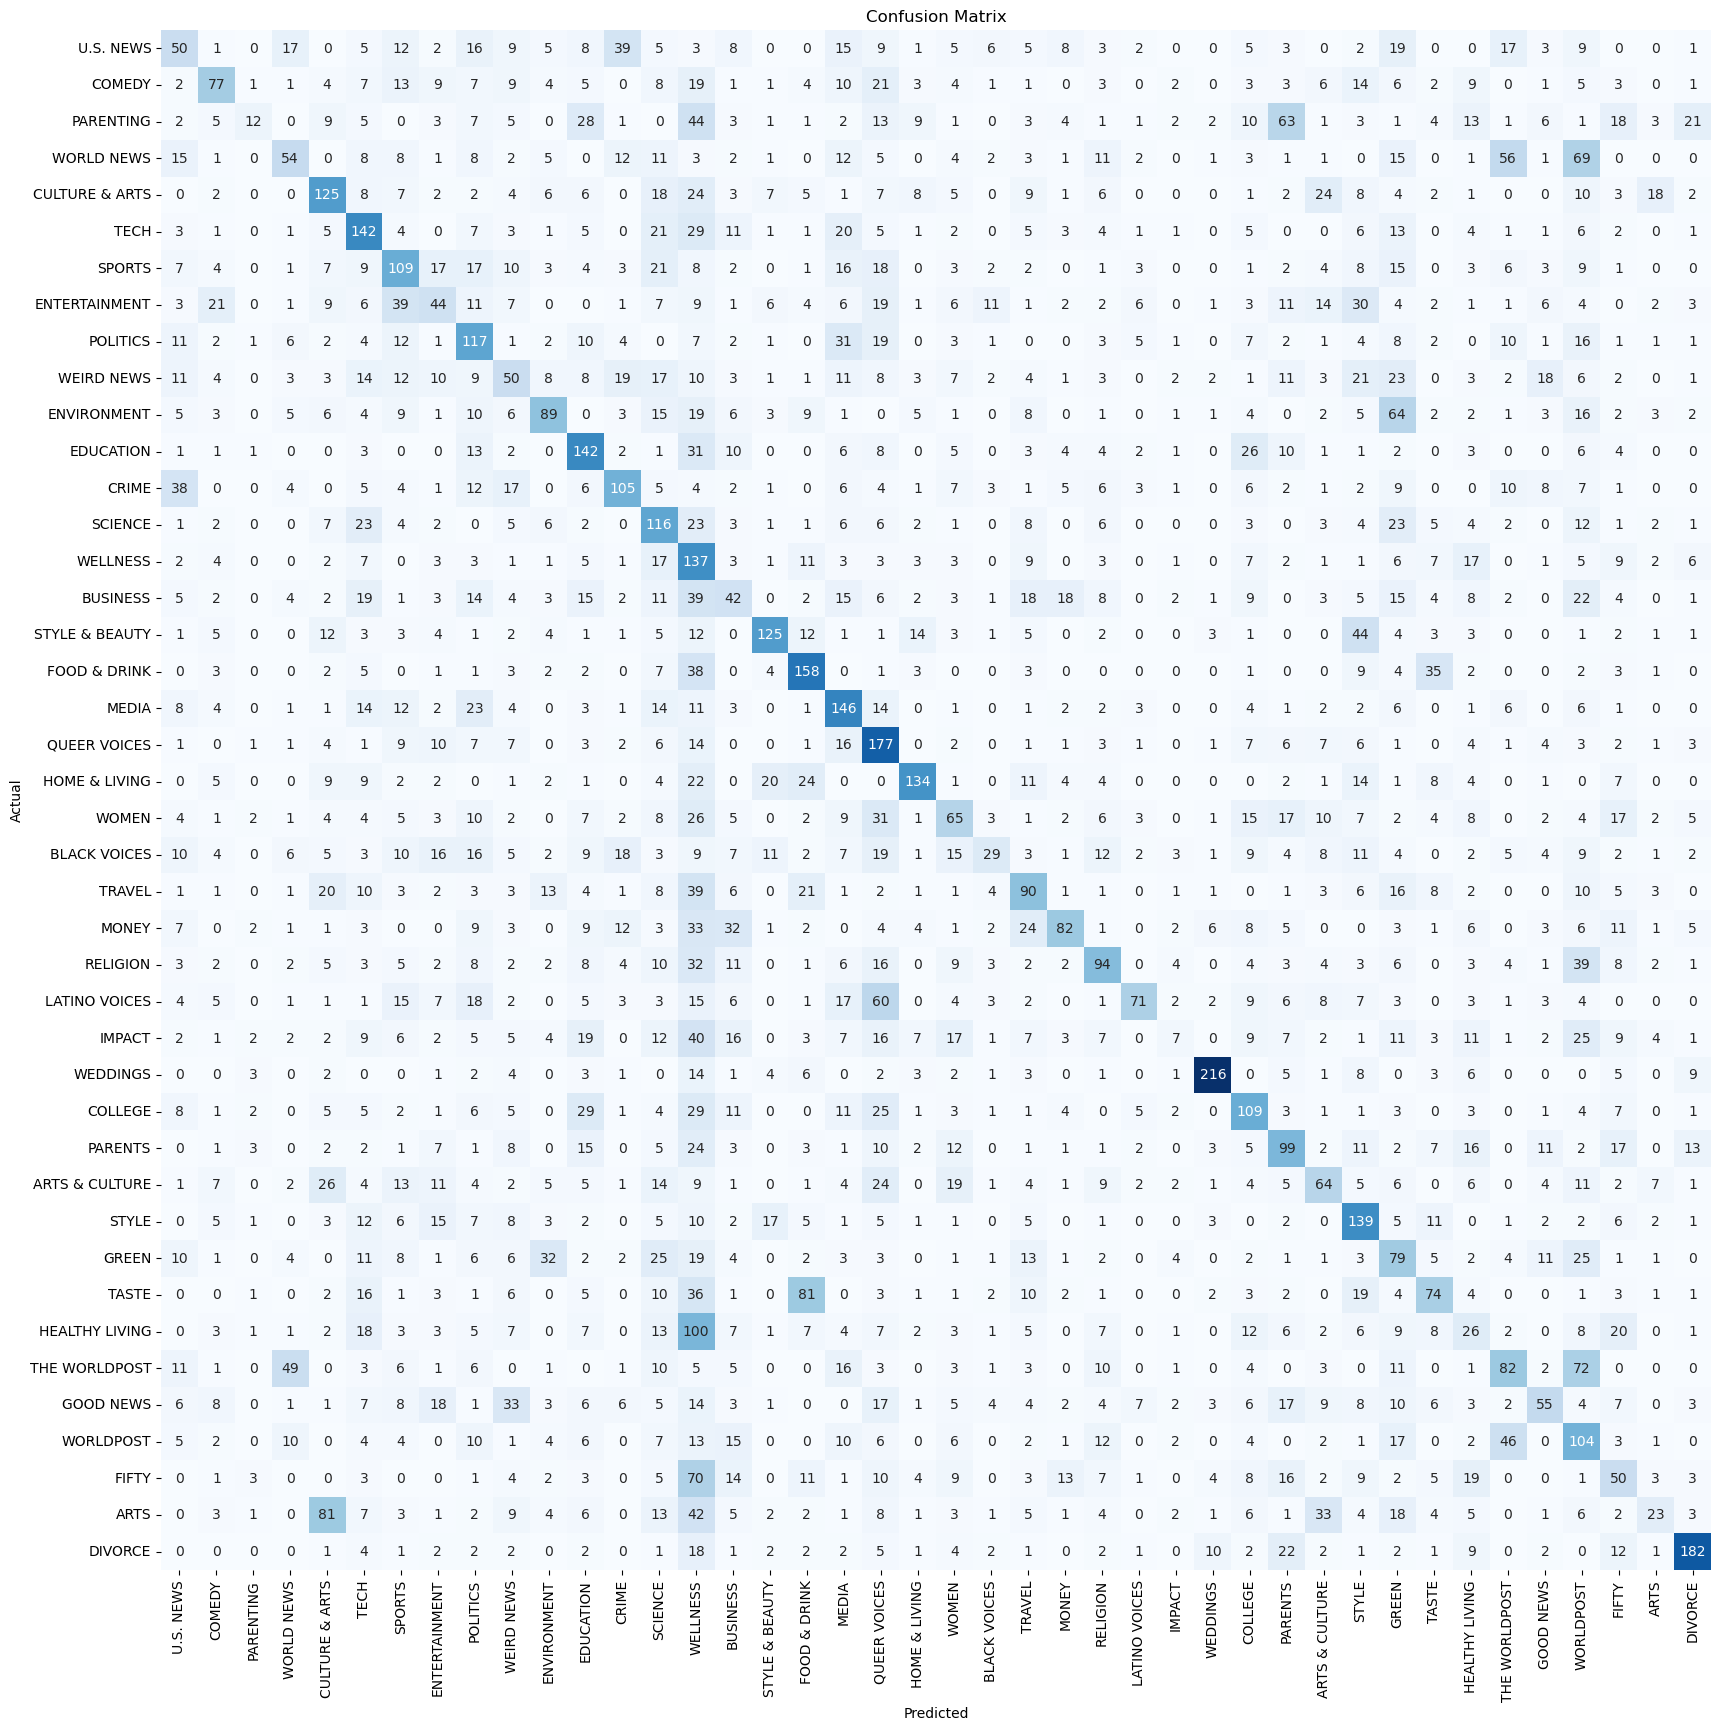

In [75]:
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(LABEL_MAPPING.keys()), rotation=90)
plt.yticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(LABEL_MAPPING.keys()), rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [76]:
print("Classification Report: \n-------------------------\n", clr)

Classification Report: 
-------------------------
                 precision    recall  f1-score   support

     U.S. NEWS       0.21      0.17      0.19       293
        COMEDY       0.40      0.29      0.33       270
     PARENTING       0.32      0.04      0.07       309
    WORLD NEWS       0.30      0.17      0.22       319
CULTURE & ARTS       0.34      0.38      0.36       331
          TECH       0.33      0.45      0.38       316
        SPORTS       0.30      0.34      0.32       320
 ENTERTAINMENT       0.21      0.14      0.17       305
      POLITICS       0.29      0.39      0.33       300
    WEIRD NEWS       0.19      0.16      0.17       317
   ENVIRONMENT       0.41      0.28      0.33       317
     EDUCATION       0.35      0.48      0.41       293
         CRIME       0.42      0.37      0.39       287
       SCIENCE       0.25      0.41      0.31       285
      WELLNESS       0.12      0.48      0.20       287
      BUSINESS       0.16      0.13      0.15       